In [1]:
import torch
import torch.nn as nn
from torch.functional import F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import xarray as xr
import datashader as ds
import datashader.transfer_functions as tf
import seaborn as sns
import scipy
import joblib

from IPython.display import clear_output

from functools import partial
from tqdm.notebook import tqdm
from sconf import Config

import sys

sys.path.append("..")

from classes import MLP, MultiTaskLoss
from utils import non_markovian_midprice, generate_time_one_time_two

/Users/nicholasmartin/Programming/Research/optimal-execution-kernel-decomposition/venv/lib/python3.10/site-packages/dask/dataframe/__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
rng = np.random.default_rng(123)
torch.manual_seed(123)

num_timesteps = 1000
final_time = 1
initial_price = 1
decomp_dim = 2
num_episodes = 100_000
kernel_batch_size = 64

dt = final_time / num_timesteps

# kernel_function = lambda x, y: np.exp(-((x - y) ** 2))
# kernel_function = lambda x,y: np.exp(-np.abs((x-y)))
# kernel_function = lambda x, y: 1 / (1 + np.abs(x - y) ** 0.5)
kernel_function = lambda x, y: (1 + np.abs(x - y) ** 2) ** (-0.5)
K0 = kernel_function(0, 0)

# Generate Data

# NN Approach

In [3]:
learning_rate = 1e-3
network = MLP(decomp_dim=decomp_dim, learn_price_impact=True)
optimizer = torch.optim.Adam(params=network.kernel_func.parameters(), lr=learning_rate)

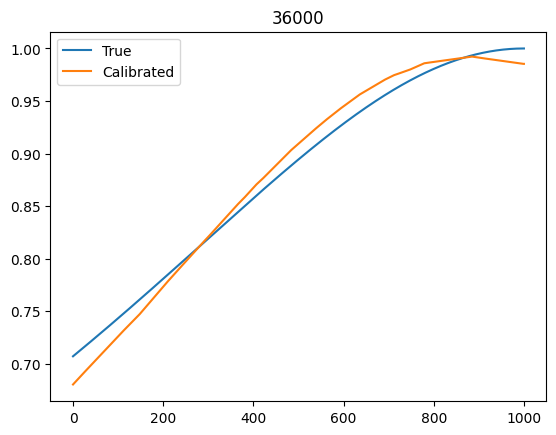

KeyboardInterrupt: 

In [4]:
loss_list = []
for i in tqdm(range(num_episodes)):

    # time_one = torch.FloatTensor(np.ones((kernel_batch_size, 1))*num_timesteps).reshape(-1, 1) * dt
    time_one_int = rng.uniform(0, num_timesteps, kernel_batch_size)
    time_one = (
        torch.FloatTensor(time_one_int).reshape(-1, 1) * dt
    )

    # time_two_int = np.array([rng.uniform(0,_) for _ in time_one*dt])
    # time_two = torch.FloatTensor(time_two_int).reshape(-1, 1) * dt
    time_two_int = rng.uniform(0, num_timesteps, kernel_batch_size)
    time_two = (
        torch.FloatTensor(time_two_int).reshape(-1, 1) * dt
    )

    K_one_two = network.approx_func(time_one, time_two).flatten()
    K_one_one = network.approx_func(time_one, time_one).flatten()
    K_one_minus = network.approx_func(time_one, 1-time_one).flatten()

    true_val = torch.FloatTensor(
        kernel_function(time_one.detach().numpy(), time_two.detach().numpy())
    ).flatten()

    true_error = torch.abs(true_val - K_one_two)
    one_error = torch.abs(K0 - K_one_one)
    # min_error = torch.abs(0.5 - K_one_minus)

    loss = (true_error**2).mean()

    loss_list.append(loss.detach().item())

    network.zero_grad()
    optimizer.zero_grad()

    loss.backward()
    optimizer.step()

    network.zero_grad()
    optimizer.zero_grad()

    if i % 1000 == 0:
        clear_output(wait=True)
        s = 1
        s_val = num_timesteps * s
        kernel_plot = []
        kernel_plot_two = []

        for _ in range(0, int(s_val)+1):
            k_s_t = network.approx_func(
                torch.FloatTensor([s_val * dt]).reshape(-1, 1),
                torch.FloatTensor([_ * dt]).reshape(1, -1),
            )
            kernel_plot.append(k_s_t.detach().item())

        max_val = 1
        # max_val = max(kernel_plot)
        kernel_plot = [_/max_val for _ in kernel_plot]

        for _ in range(0, int(s_val)+1):
            val = kernel_function(_ * dt, s_val * dt)
            kernel_plot_two.append(val)

        plt.title(i)

        plt.plot(kernel_plot_two, label="True")
        plt.plot(kernel_plot, label="Calibrated")
        plt.legend()
        plt.show()

# Calibrating Price Impact Given Learnt Kernel

In [5]:
num_paths = 1
num_episodes = 100_000
batch_size = 1
dt = final_time / num_timesteps

inital_prices = np.ones((1, num_paths)) * initial_price

nu_vals = rng.integers(-100, 100, size=(num_timesteps, num_paths))

permenant_price_impact_func = lambda nu: np.sign(nu) * np.sqrt(np.abs(nu))

sigma_true = 0.001
sim_prices, noise_process = non_markovian_midprice(
    inital_prices=inital_prices,
    permenant_price_impact_func=permenant_price_impact_func,
    nu_vals=nu_vals,
    kernel_function=kernel_function,
    dt=dt,
    rng=rng,
    num_paths=num_paths,
    num_timesteps=num_timesteps,
    sigma=sigma_true,
)

pi_optimizer = torch.optim.Adam(params=[*network.price_impact.parameters(), 
                                        *network.model_parameters.parameters()], lr=1e-4)

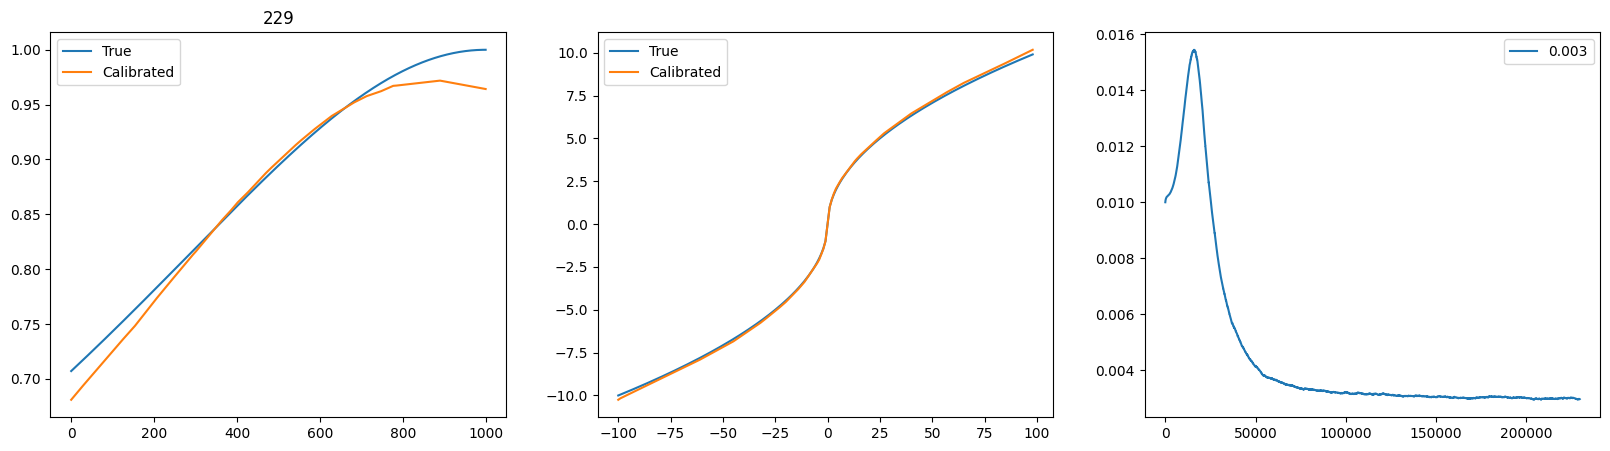

KeyboardInterrupt: 

In [6]:
pi_train_flag = True
pi_flag_counter = 0

loss_vals = {}
sigma_tracker = {}
kappa_tracker = {}
for episode in tqdm(range(num_episodes), position=0, leave=True):
    loss_vals[episode] = []
    sigma_tracker[episode] = []
    kappa_tracker[episode] = []
    for batch_index in range(1, int(num_paths / batch_size) + 1):

        lower_bound = int((batch_index - 1) * batch_size)
        upper_bound = int((batch_index) * batch_size)

        B_n_t = torch.zeros((batch_size, decomp_dim))

        true_vals = sim_prices[:, lower_bound:upper_bound]
        batch_nu_vals = nu_vals[:, lower_bound:upper_bound]

        shuffeled_timesteps = np.arange(1, num_timesteps - 1)

        # Shuffle Timestamps
        rng.shuffle(shuffeled_timesteps)

        for timestep in shuffeled_timesteps:

            pi_flag_counter += 1

            true_vals_t = torch.FloatTensor(true_vals[timestep, :])
            true_vals_t_plus_one = torch.FloatTensor(true_vals[timestep + 1, :])

            batch_nu_vals_t = torch.FloatTensor(batch_nu_vals[timestep])
            price_impacts = network.permenant_price_impact_func(
                batch_nu_vals_t
            ).reshape(batch_size)

            # time_tensor = torch.FloatTensor([num_timesteps * dt])
            time_tensor = torch.FloatTensor([timestep * dt])
            f_vals = network(time_tensor)
            K_t_t = network.approx_func(
                time_tensor.reshape(-1, 1), time_tensor.reshape(-1, 1)
            ).flatten()
            # K_t_t = torch.FloatTensor([1])

            # Calculate Second f(X_t, t; \theta) term
            # Calcutate f_n'(t)
            all_time_tensor = (
                torch.arange(0, timestep) * dt
            ).reshape(-1, 1)
            B_n_t = torch.zeros((1, batch_size, decomp_dim))
            d_B_n_s = (
                network(all_time_tensor).reshape(timestep, 1, decomp_dim)
                * network.permenant_price_impact_func(
                    torch.FloatTensor(batch_nu_vals[:timestep]).reshape(
                        timestep, batch_size, 1
                    )
                ).reshape(timestep, batch_size, 1)
                * dt
            )

            # Do I want [:-1] or not?
            B_n_t = torch.vstack([B_n_t, d_B_n_s])
            B_n_t = torch.sum(B_n_t, axis=0)

            delta = torch.FloatTensor([dt])
            time_minus_delta = time_tensor - delta
            time_plus_delta = time_tensor + delta
            f_prime_vals = (
                (network(time_plus_delta) - network(time_minus_delta)) / (2 * delta)
            ).flatten()

            # Calculate first f(X_t, t; \theta) term
            f_x_t_one = price_impacts.reshape(batch_size) * K_t_t

            f_x_t_two = (
                B_n_t.reshape(batch_size, decomp_dim)
                * f_prime_vals.reshape(1, decomp_dim)
            ).sum(dim=1)

            f_x_t = f_x_t_one + f_x_t_two

            L_x_t = network.sigma#.detach()
            term_one = 0.5 * torch.log(torch.abs(2 * torch.pi * (L_x_t**2) * dt))

            term_two = (((true_vals_t_plus_one - true_vals_t) - f_x_t * dt) ** 2) / (
                2 * dt * (L_x_t**2)
            )

            likely_hood_loss = term_one + term_two
            ##################################################################################

            loss = likely_hood_loss.mean()

            sigma_tracker[episode].append(network.sigma.detach().item())
            loss_vals[episode].append(
                {
                    "mt_loss": loss.detach().item(),
                }
            )

            if pi_flag_counter % 100 == True:
                pi_train_flag = not pi_train_flag

            network.zero_grad()
            optimizer.zero_grad()

            loss.backward()
            pi_optimizer.step()

            network.zero_grad()
            optimizer.zero_grad()

    if episode % 1 == 0:
        clear_output(wait=True)
        s = 1
        s_val = num_timesteps * s
        kernel_plot = []
        kernel_plot_two = []
        pi_plot = []
        pi_plot_true = []

        fig, ax = plt.subplots(1, 3, figsize=(20, 5))

        for i in range(num_timesteps - int(s_val), num_timesteps + 1):
            k_s_t = network.approx_func(
                torch.FloatTensor([num_timesteps * dt]).reshape(-1, 1),
                torch.FloatTensor([i * dt]).reshape(1, -1),
            )
            kernel_plot.append(k_s_t.detach().item())

        for i in range(num_timesteps - int(s_val), num_timesteps + 1):
            val = kernel_function(x=i * dt, y=num_timesteps * dt)
            kernel_plot_two.append(val)

        # max_k_val = max(kernel_plot)
        max_k_val = 1
        kernel_plot = [_ / max_k_val for _ in kernel_plot]

        for plot_val in range(nu_vals.min(), nu_vals.max()):
            pred_pi = network.permenant_price_impact_func(torch.FloatTensor([plot_val]))
            pi_plot.append(pred_pi.detach().item() * max_k_val)

        for plot_val in range(nu_vals.min(), nu_vals.max()):
            val = permenant_price_impact_func(plot_val)
            pi_plot_true.append(val)

        ax[0].set_title(episode)
        ax[0].plot(kernel_plot_two, label="True")
        ax[0].plot(kernel_plot, label="Calibrated")
        ax[0].legend()

        ax[1].plot(range(nu_vals.min(), nu_vals.max()), pi_plot_true, label="True")
        ax[1].plot(range(nu_vals.min(), nu_vals.max()), pi_plot, label="Calibrated")
        ax[1].legend()

        ax[2].plot(
            np.hstack([_ for _ in sigma_tracker.values()]),
            label=round(network.sigma.item(), 3),
        )
        ax[2].legend()

        plt.show()

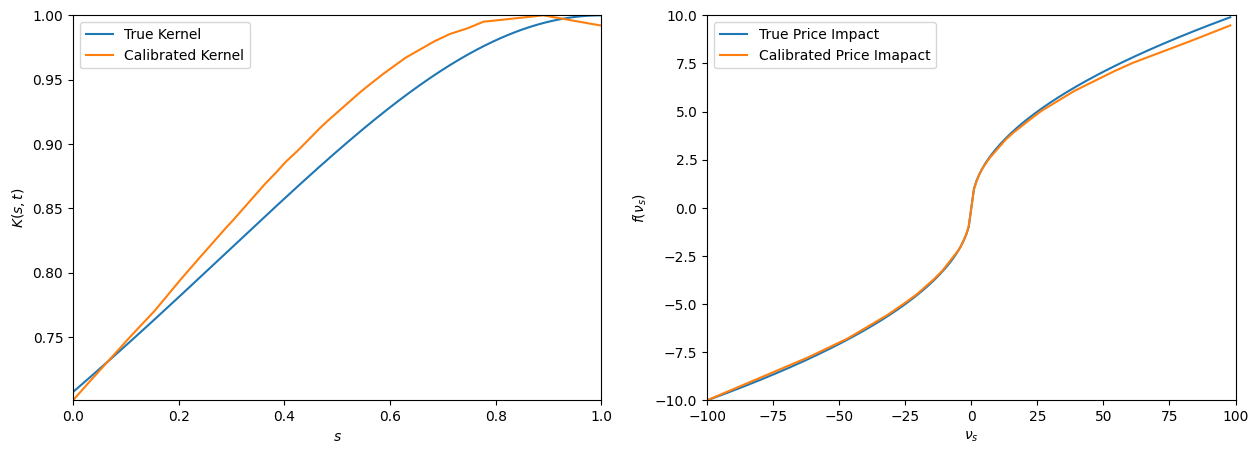

In [7]:
s = 1
s_val = num_timesteps * s
kernel_plot = []
kernel_plot_two = []
pi_plot = []
pi_plot_true = []

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

for i in range(num_timesteps - int(s_val), num_timesteps + 1):
    k_s_t = network.approx_func(
        torch.FloatTensor([num_timesteps * dt]).reshape(-1, 1),
        torch.FloatTensor([i * dt]).reshape(1, -1),
    )
    kernel_plot.append(k_s_t.detach().item())

for i in range(num_timesteps - int(s_val), num_timesteps + 1):
    val = kernel_function(x=i * dt, y=num_timesteps * dt)
    kernel_plot_two.append(val)

max_k_val = max(kernel_plot)
# max_k_val = 1
kernel_plot = [_ / max_k_val for _ in kernel_plot]

for plot_val in range(nu_vals.min(), nu_vals.max()):
    pred_pi = network.permenant_price_impact_func(torch.FloatTensor([plot_val]))
    pi_plot.append(pred_pi.detach().item() * max_k_val)

for plot_val in range(nu_vals.min(), nu_vals.max()):
    val = permenant_price_impact_func(plot_val)
    pi_plot_true.append(val)

# ax[0].set_title(episode)
ax[0].plot(np.linspace(0, 1, len(kernel_plot_two)), kernel_plot_two, label="True Kernel")
ax[0].plot(np.linspace(0, 1, len(kernel_plot)), kernel_plot, label="Calibrated Kernel")
ax[0].set_xlim(0, 1)
ax[0].set_ylim(min(min(kernel_plot), min(kernel_plot_two)), 1)
ax[0].set_ylabel(r'$K(s, t)$')
ax[0].set_xlabel(r'$s$')
ax[0].legend()

ax[1].plot(range(nu_vals.min(), nu_vals.max()), pi_plot_true, label="True Price Impact")
ax[1].plot(range(nu_vals.min(), nu_vals.max()), pi_plot, label="Calibrated Price Imapact")
ax[1].set_xlim(-100, 100)
ax[1].set_ylim(-10, 10)
ax[1].set_ylabel(r'$f\left( \nu_{s} \right)$')
ax[1].set_xlabel(r'$\nu_{s}$')
ax[1].legend()

# plt.savefig('../figures/fractional_learn_kernel_directly.pdf')

plt.show()